In [23]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/home/hieutt/UniCon/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../', '../', '../']


In [21]:
from dataset import CANDataset
import torch
from torchvision import transforms, datasets
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [47]:
train_dataset = CANDataset(
    root_dir='../data/Car-Hacking/TFRecord_w32_s32/2',
    window_size=32, is_train=True)
# train_dataset.total_size = 1000
train_sampler = None
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=False,
    num_workers=2, pin_memory=True, sampler=train_sampler)

In [22]:
val_dataset = CANDataset(
    root_dir='../data/Car-Hacking/TFRecord_w32_s32/2',
    window_size=32, is_train=False)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2048, shuffle=False,
    num_workers=8, pin_memory=True, sampler=None)

In [48]:
import torch.optim as optim
# from networks.classifier import LinearClassifier
from networks.resnet_big import ConResNet
from networks.resnet_big import LinearClassifier

model = ConResNet('resnet50')
classifier = LinearClassifier(num_classes=5)

In [27]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [28]:
# save_path = '../save/SupCon_resnet182_lr0.1_0.01_bs512_100epoch_temp0.07_092024_115823_cosine_warm/'
ckpt_epoch = 100
# model_path = f'{save_path}/last.pth'
# /home/hieutt/UniCon/save/path_models/UniCon/UniCon_path_resnet50_lr_0.05_decay_0.0001_bsz_64_temp_0.1_mixup_lambda_0.5_trial_0/ckpt_epoch_5.pth
model_path = '../save/path_models/UniCon/UniCon_path_resnet50_lr_0.05_decay_0.0001_bsz_64_temp_0.1_mixup_lambda_0.5_trial_0/ckpt_epoch_5.pth'
ckpt = torch.load(model_path)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

/tmp/ipykernel_182385/3080378037.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path)


<All keys matched successfully>

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Your confusion matrix tensor
confusion_matrix_tensor = torch.tensor([
    [95882,     0,     0,     0,     0],
    [   73, 10116,     0,     1,     0],
    [   13,     0, 12089,     0,     0],
    [   30,     0,     0, 17729,     0],
    [    5,     0,     0,     0, 19405]
], device='cuda:0')

# Move to CPU and convert to NumPy
confusion_matrix = confusion_matrix_tensor.cpu().numpy()


In [5]:
class_labels = ['Normal', 'DoS', 'Fuzzy', 'Gear Spoof', 'RPM Spoof']

In [6]:
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues, normalize=False):
    """
    Plots a confusion matrix using seaborn heatmap.

    Parameters:
    - cm (array-like): Confusion matrix.
    - class_names (list): List of class names.
    - title (str): Title of the plot.
    - cmap: Color map for the heatmap.
    - normalize (bool): Whether to normalize the confusion matrix.
    """
    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_to_plot = cm_normalized
        fmt = '.2f'
        ylabel = 'True label'
        xlabel = 'Predicted label'
        colorbar_label = 'Normalized Frequency'
    else:
        cm_to_plot = cm
        fmt = 'd'
        ylabel = 'True label'
        xlabel = 'Predicted label'
        colorbar_label = 'Count'

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_to_plot, annot=True, fmt=fmt, cmap=cmap, 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': colorbar_label})
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()


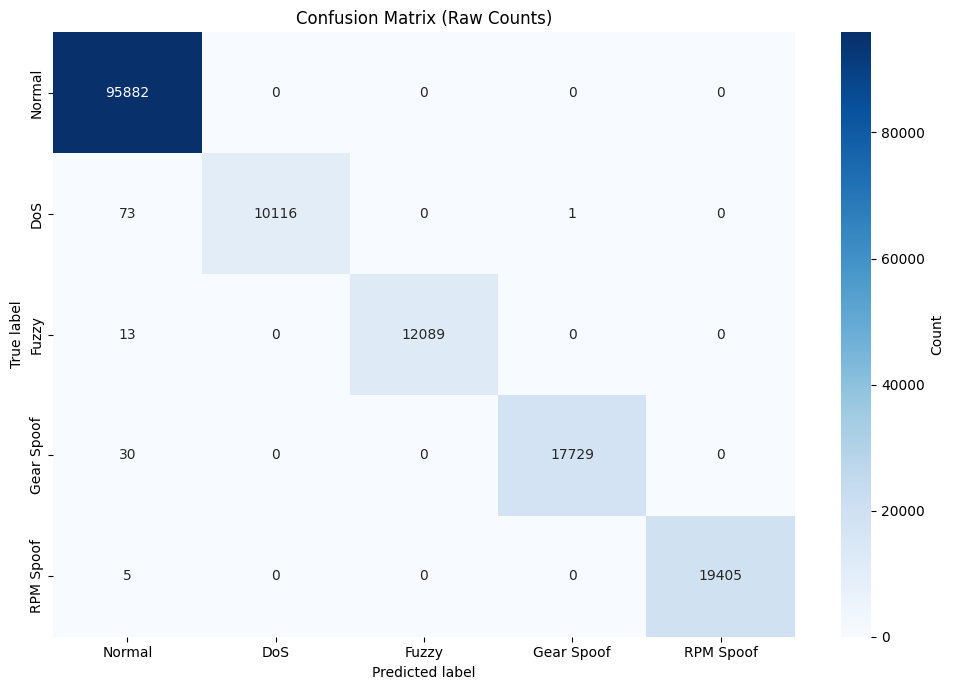

In [7]:
plot_confusion_matrix(confusion_matrix, class_labels, title='Confusion Matrix (Raw Counts)', normalize=False)


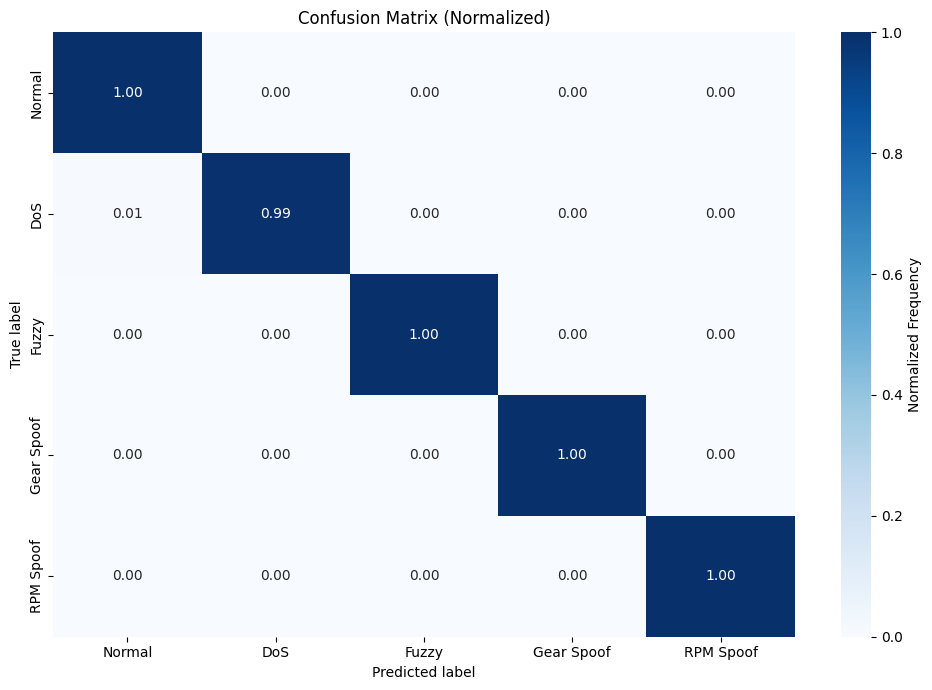

In [8]:
plot_confusion_matrix(confusion_matrix, class_labels, title='Confusion Matrix (Normalized)', normalize=True)
